**About** : This notebook is used to prepare the data


In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

## Initialization

### Imports

In [2]:
import os
import sys
import cv2
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

sys.path.append("../src/")

In [3]:
from params import *
from utils.rle import *
from utils.plots import *
from data.masks import *

## Data

In [4]:
df = pd.read_csv(DATA_PATH + "train.csv")

In [5]:
df = df.groupby('id').agg(list).reset_index()

In [6]:
for col in df.columns[2:]:
    df[col] = df[col].apply(lambda x: np.unique(x)[0] if len(np.unique(x)) == 1 else np.unique(x))

In [7]:
df.head()

id                                         annotation  width  \
0  0030fd0e6378  [118145 6 118849 7 119553 8 120257 8 120961 9 ...    704   
1  0140b3c8f445  [32499 3 33201 7 33902 9 34604 10 35306 11 360...    704   
2  01ae5a43a2ab  [241026 3 241726 9 242427 13 243130 14 243834 ...    704   
3  026b3c2c4b32  [170753 5 171454 12 172158 13 172862 13 173565...    704   
4  029e5b3b89c7  [139142 7 139845 10 140548 13 141251 15 141955...    704   

   height cell_type plate_time sample_date  \
0     520    shsy5y  11h30m00s  2019-06-16   
1     520     astro  09h00m00s  2020-09-13   
2     520      cort  13h30m00s  2020-11-04   
3     520      cort  19h30m00s  2020-11-04   
4     520      cort  13h30m00s  2020-10-27   

                              sample_id elapsed_timedelta  
0    shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1    astros[cereb]_F8-3_Vessel-361_Ph_4   0 days 09:00:00  
2   cort[oka-high]_B5-1_Vessel-377_Ph_1   0 days 13:30:00  
3    cort[oka-low]_H6-2_Vessel-377_Ph_2   0 days 19:30:00  
4  cort[pre-treat]_B8-2_Vessel-377_Ph_2   0 days 13:30:00

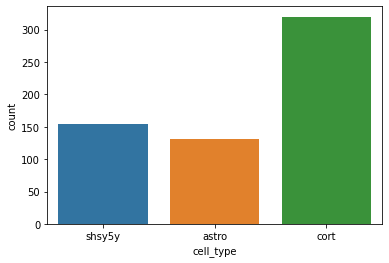

In [8]:
sns.countplot(x=df['cell_type'])
plt.show()

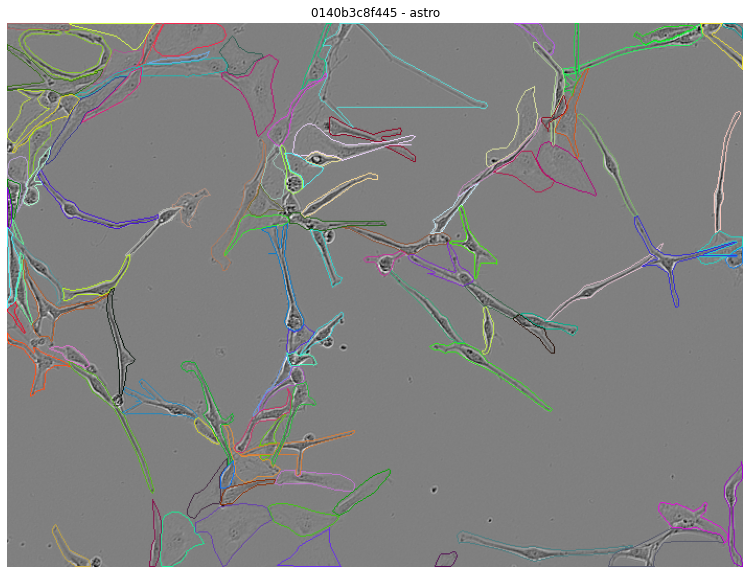

In [14]:
for _ in range(5):
#     idx = np.random.choice(len(df))
    idx = 1

    img = cv2.imread(TRAIN_IMG_PATH + df['id'][idx] + ".png")

    rles = df['annotation'][idx]
    
    mask = rles_to_mask_fix(rles, img.shape[:2])
    
    plt.figure(figsize=(15, 10))
    plot_sample(img, mask, width=1)
    plt.axis(False)
    plt.title(f"{df['id'][idx]} - {df['cell_type'][idx]}")
    plt.show()
    
    break

## Contours & distance

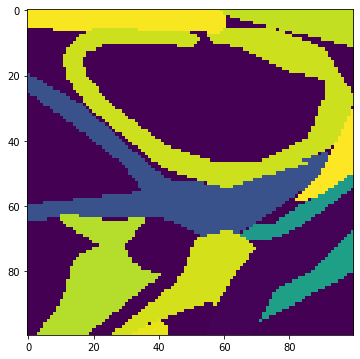

In [16]:
plt.figure(figsize=(6, 6))
m = mask[:100, : 100]

plt.imshow(m)

In [17]:
contour = mask_to_contour(mask, pad=1)

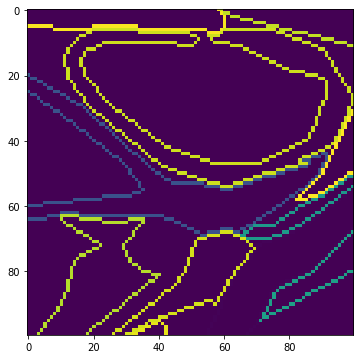

In [18]:
plt.figure(figsize=(6, 6))
plt.imshow(contour[:100, :100], interpolation="none")

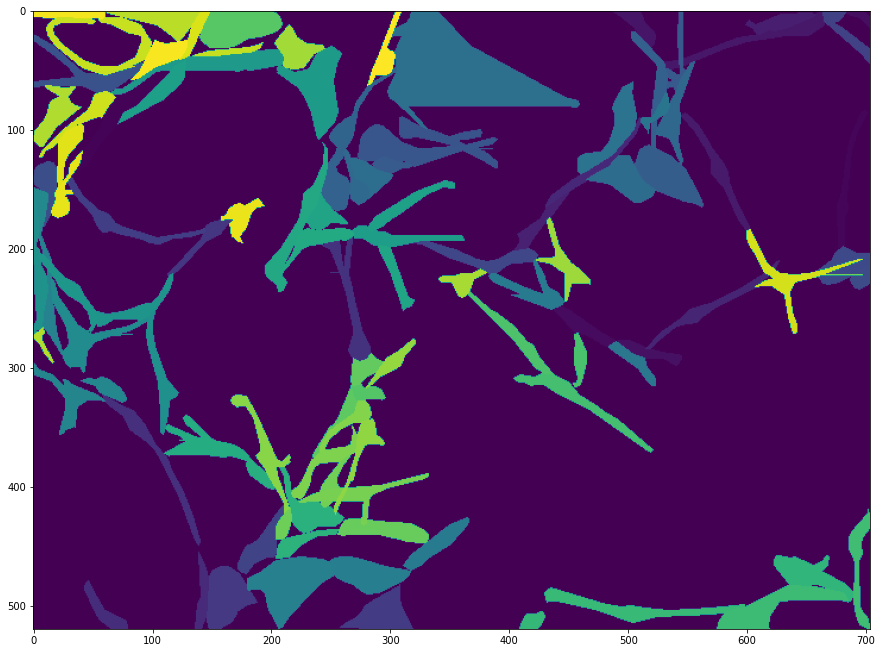

In [20]:
plt.figure(figsize=(15, 15))
plt.imshow(mask)
plt.show()

In [21]:
border = keep_cell_to_cell_only(contour, mask)

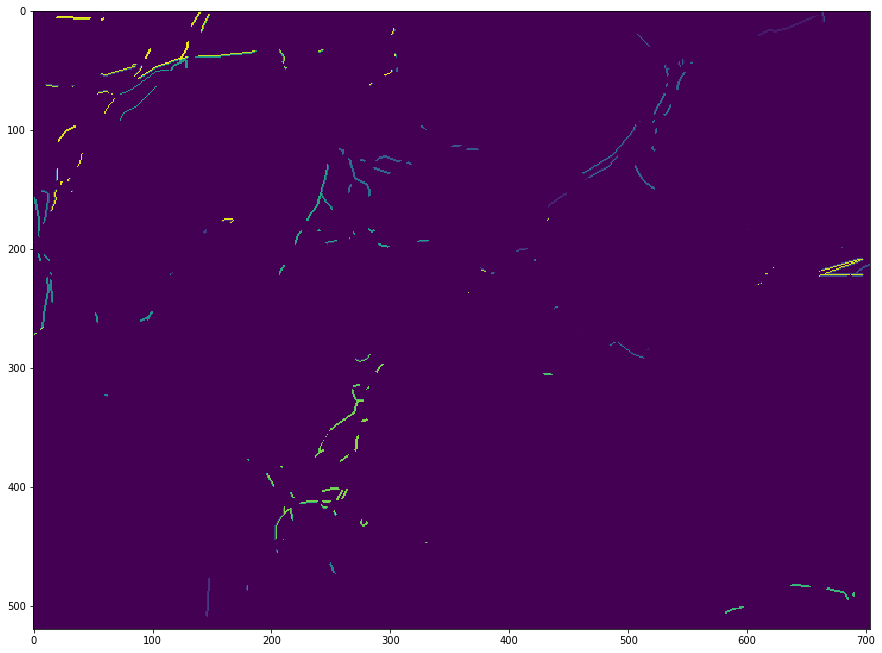

In [23]:
plt.figure(figsize=(15, 15))
plt.imshow(border, interpolation="none")
plt.show()

In [36]:
distances = get_distances(contour, mask, scale_factor=5)

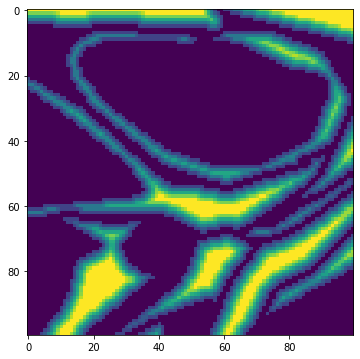

In [37]:
plt.figure(figsize=(6, 6))
plt.imshow(distances[:100, :100].astype(float) / np.max(distances))

## Generation

In [40]:
SAVE = True
PLOT = True
WIDTH = 2

SAVE_DIR = OUT_PATH + f"proc_train_{WIDTH}/" 

if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

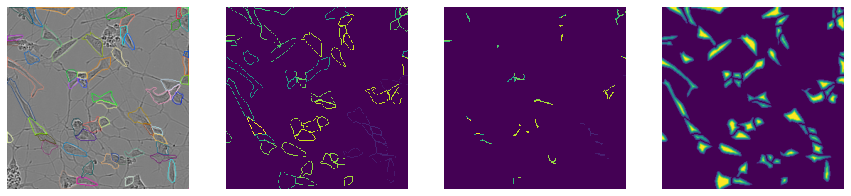

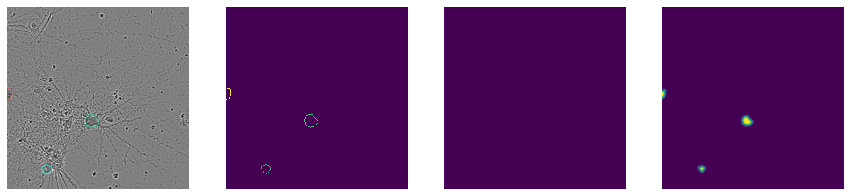

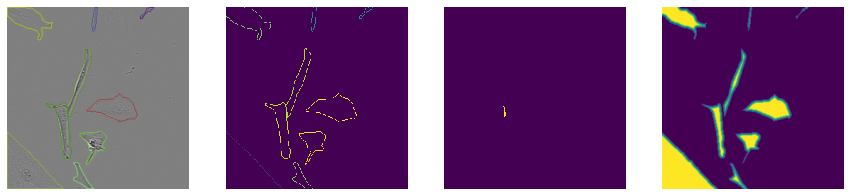

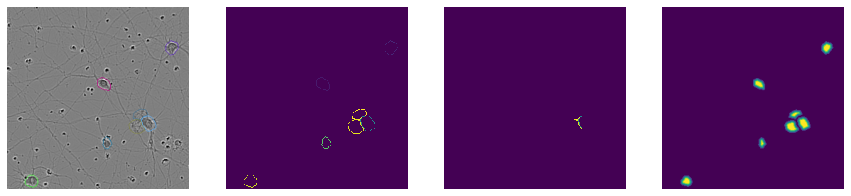

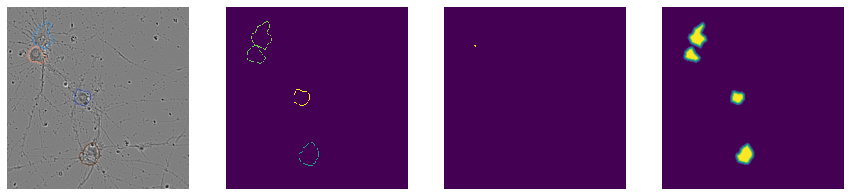

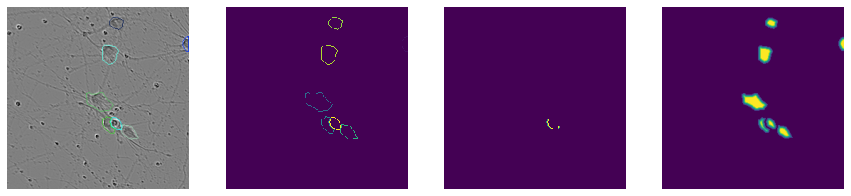

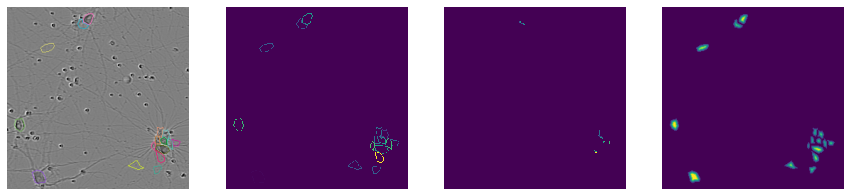

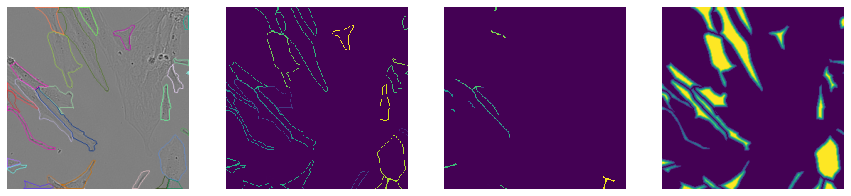

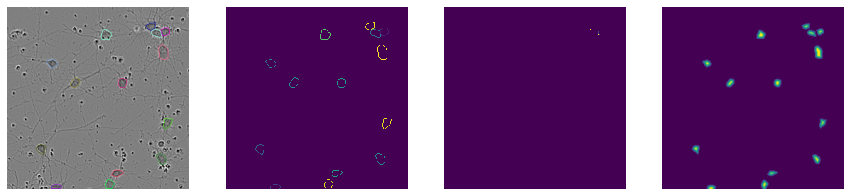

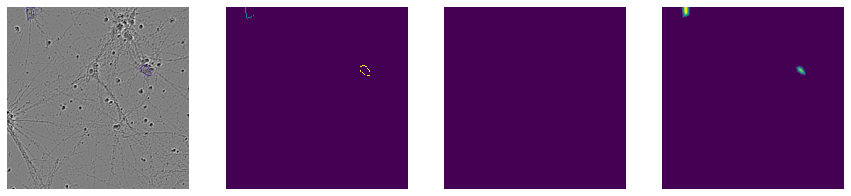

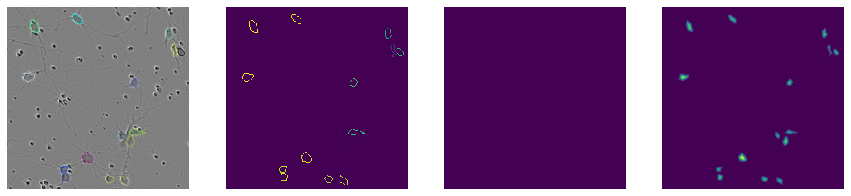

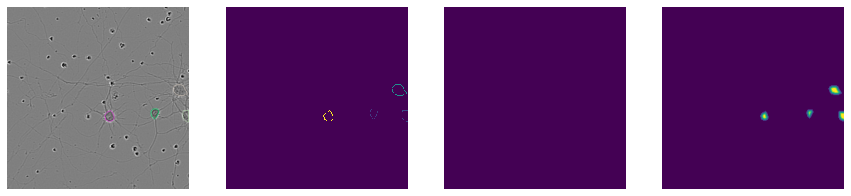

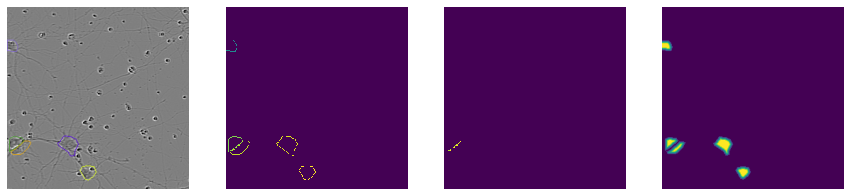

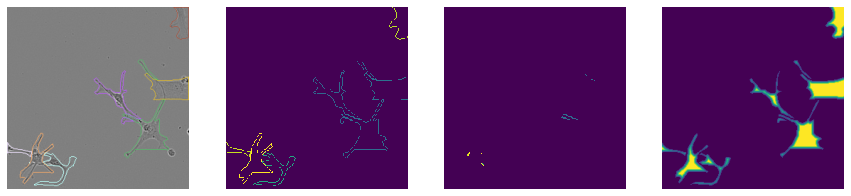

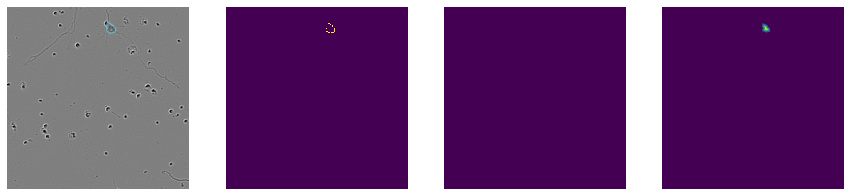

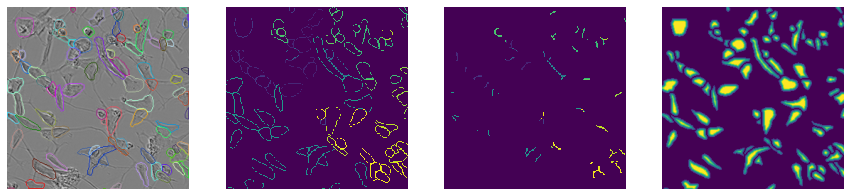

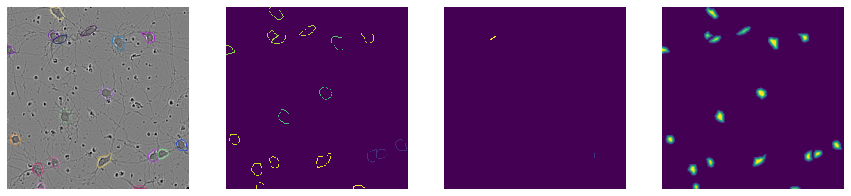

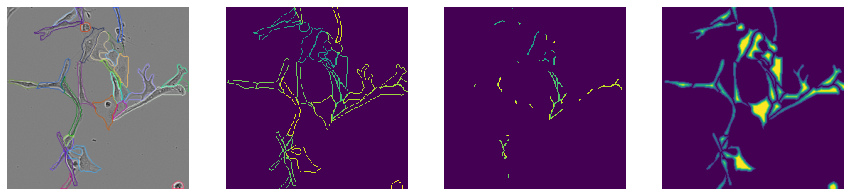

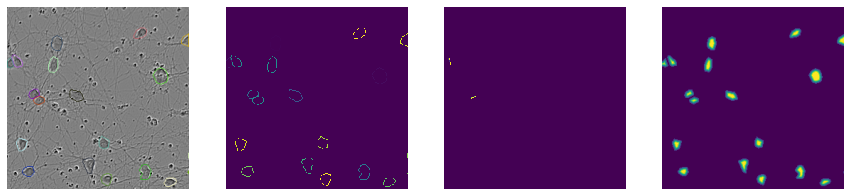

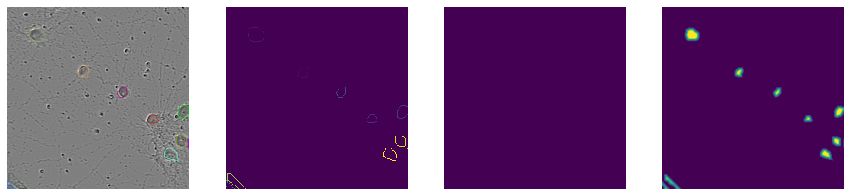

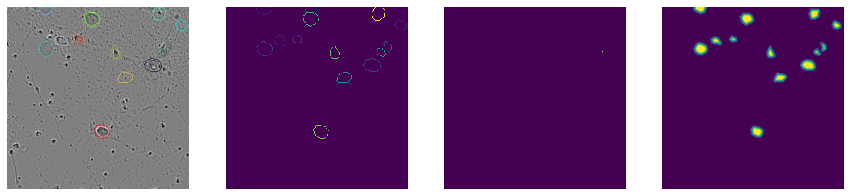

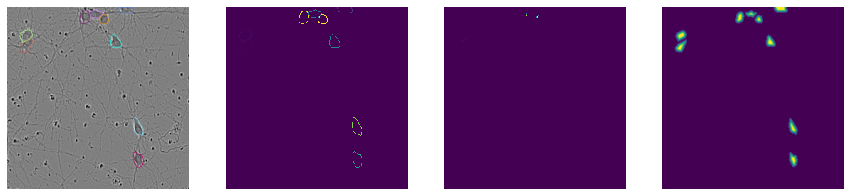

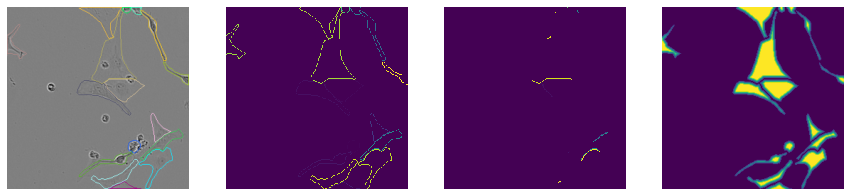

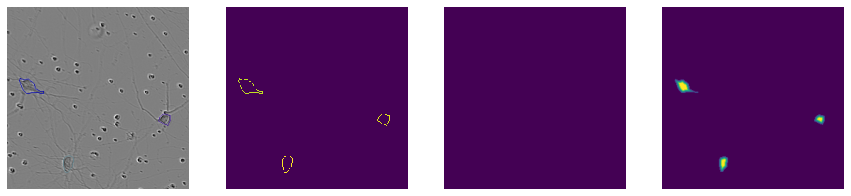

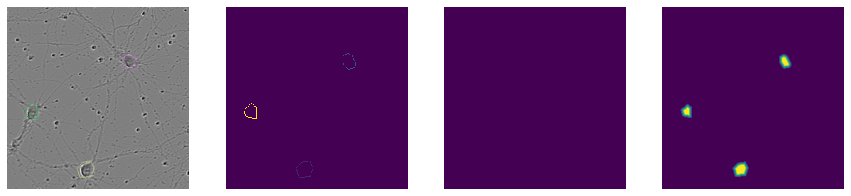

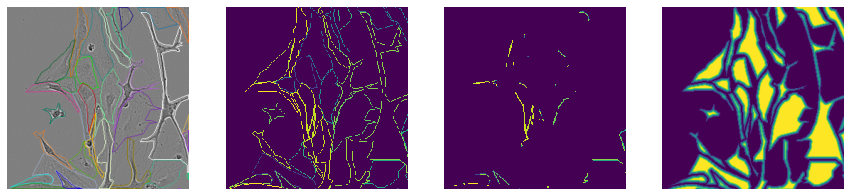

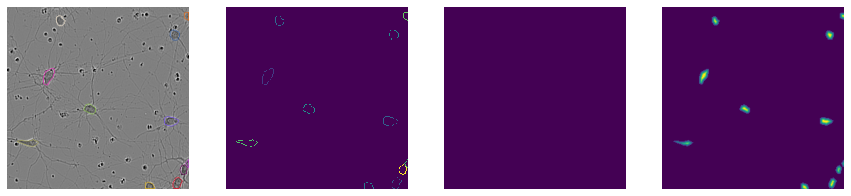

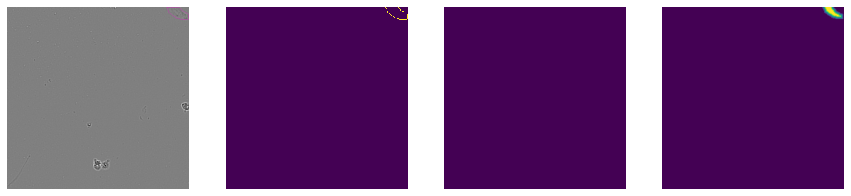

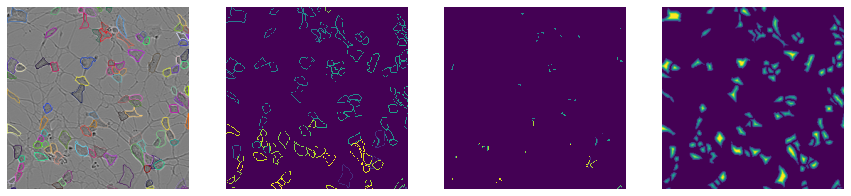

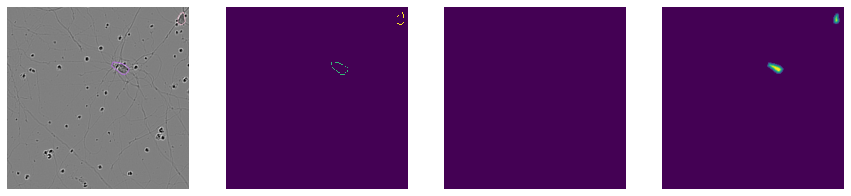

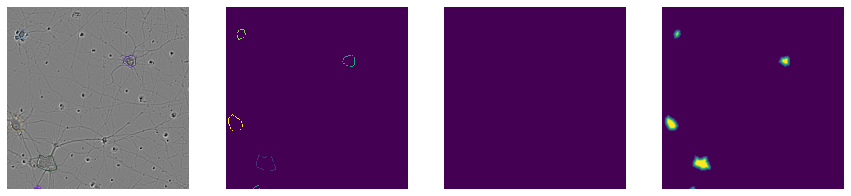

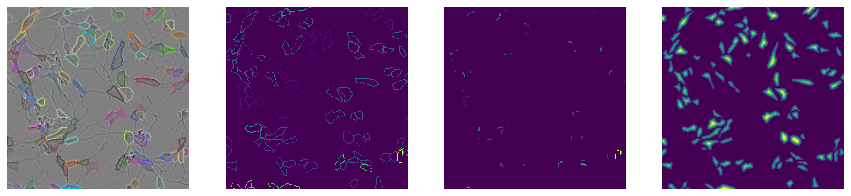

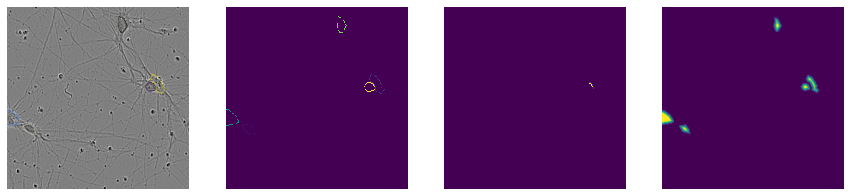

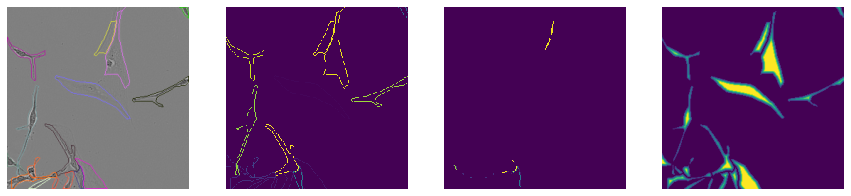

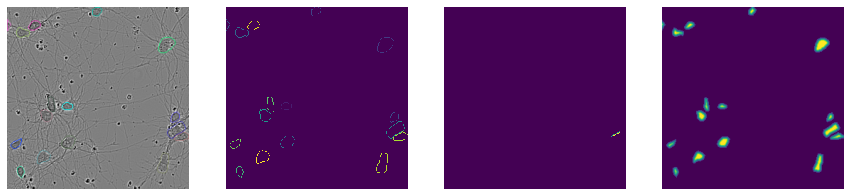

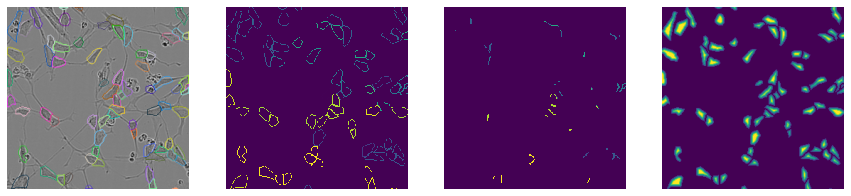

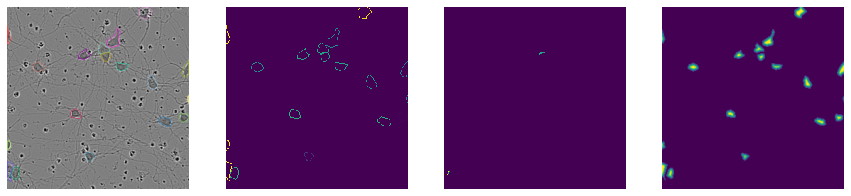

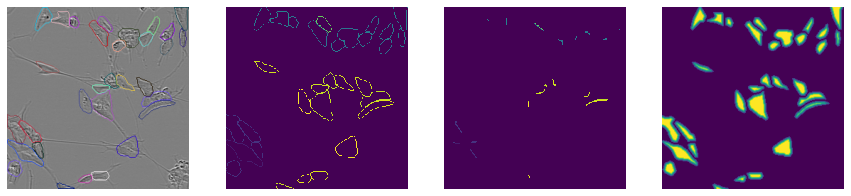

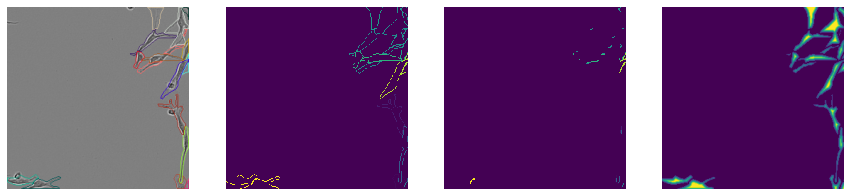

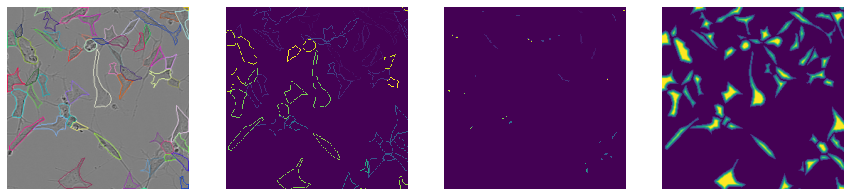

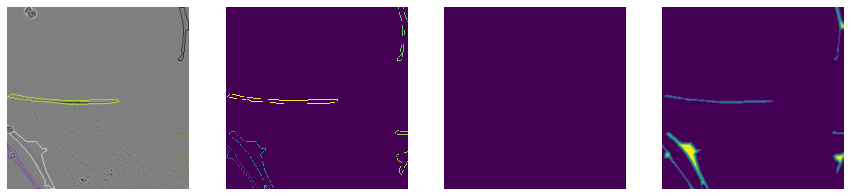

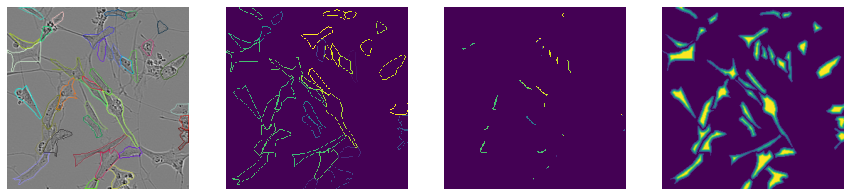

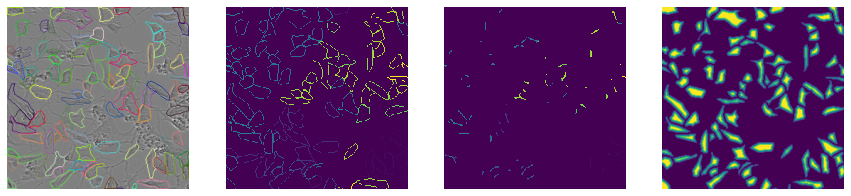

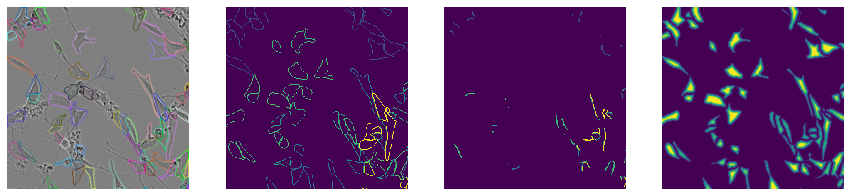

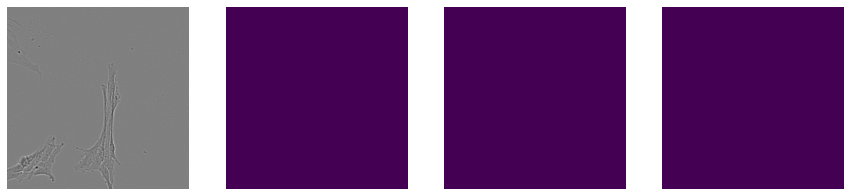

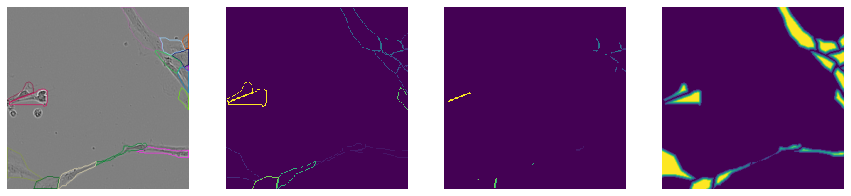

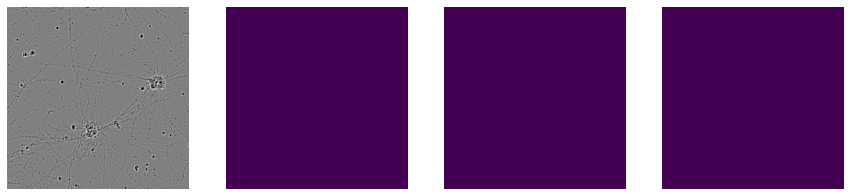

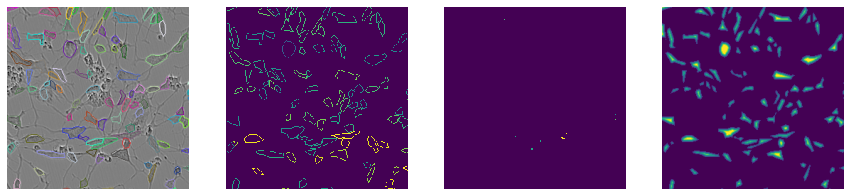

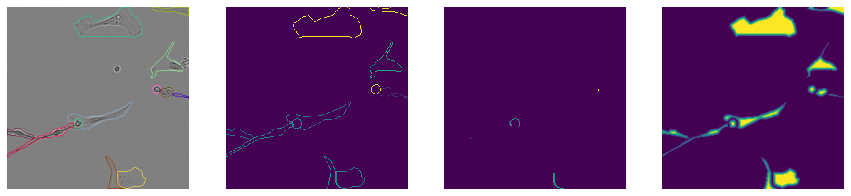

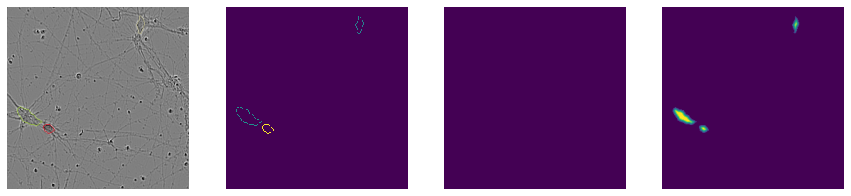

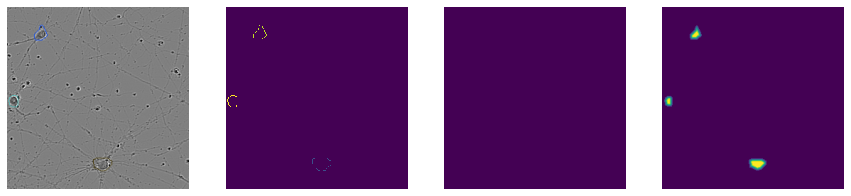

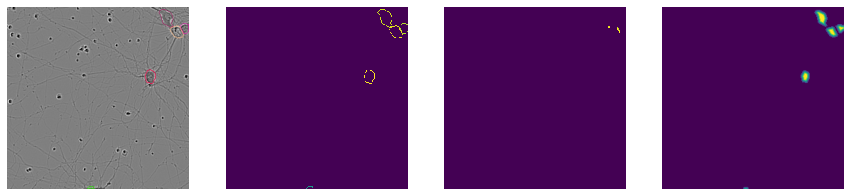

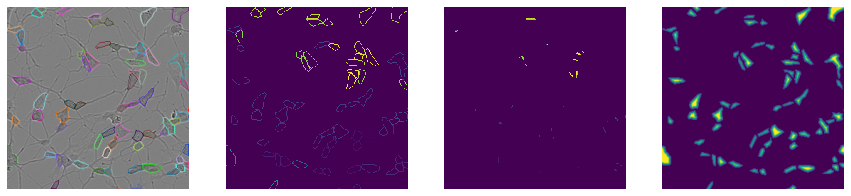

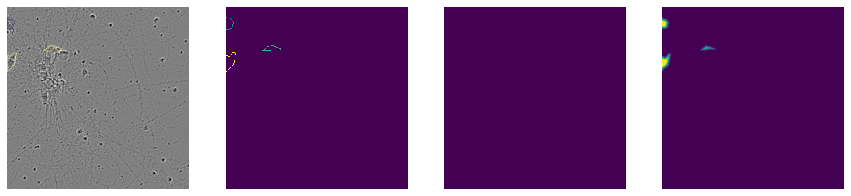

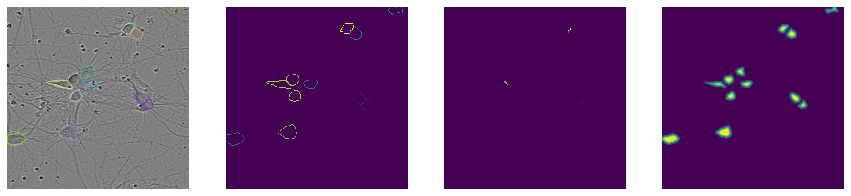

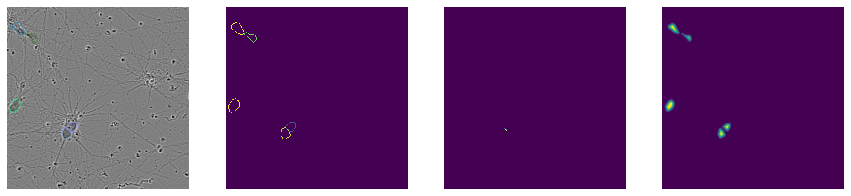

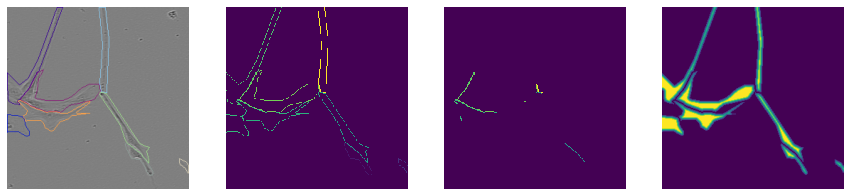

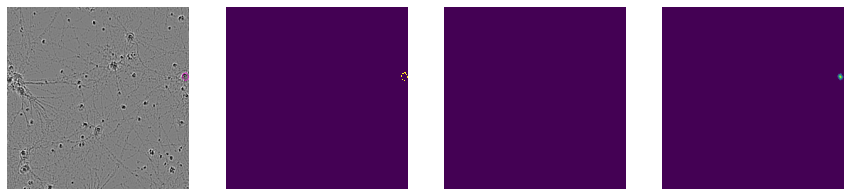

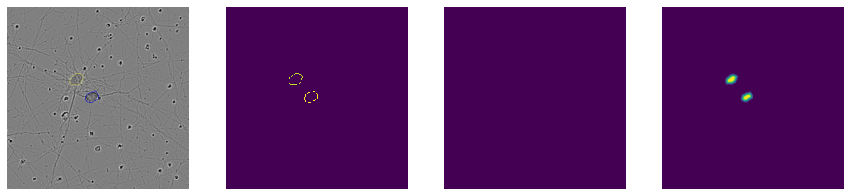

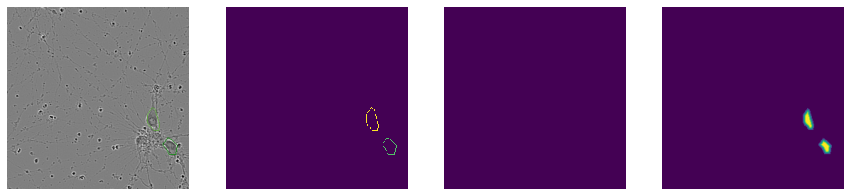

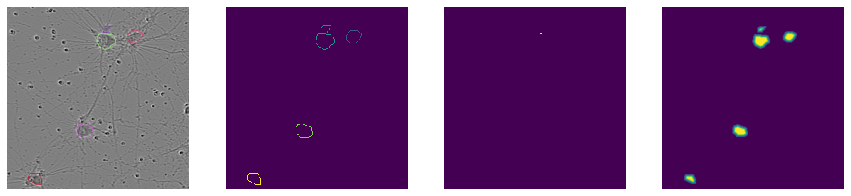

In [41]:
for i in tqdm(range(len(df))):
    shape = df[['height', 'width']].values[i]
    
    rles = df['annotation'][i]
    
    masks = rles_to_mask_fix(rles, img.shape[:2]).astype(np.uint16)
    
    contours = mask_to_contour(masks, width=1, pad=1)
    contours_between = keep_cell_to_cell_only(contours.copy(), masks)
    distances = get_distances(contours, masks, scale_factor=5)
    
    if PLOT and (i % 10) == 0:
        img = cv2.imread(TRAIN_IMG_PATH + df['id'][i] + ".png")
        n = 256

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 4, 1)
        plot_sample(img[:n, :n], masks[:n, :n])
        plt.axis(False)
        
        plt.subplot(1, 4, 2)
        plt.imshow(contours[:n, :n], interpolation="none")
        plt.axis(False)
        
        plt.subplot(1, 4, 3)
        plt.imshow(contours_between[:n, :n], interpolation="none")
        plt.axis(False)
        
        plt.subplot(1, 4, 4)
        plt.imshow(distances[:n, :n] / 10000.)
        plt.axis(False)
        plt.show()

    if SAVE:
        mcd = np.concatenate([
            masks[None], contours_between[None], distances[None],
        ])
        
        np.save(SAVE_DIR + f"{df['id'][i]}.npy", mcd)

#     break